## Providing data-driven suggestions for HR

### Project Overview
The primary objective of this project is to enhance employee retention and job satisfaction within the company by identifying key factors influencing employee turnover. By analyzing the underlying causes of low job satisfaction and determining the most significant predictors of whether an employee will choose to stay or leave, we aim to provide actionable insights and recommendations for the HR department.

To achieve this, we will develop a Logistic Regression model that predicts employee attrition, enabling the company to proactively address issues before they lead to turnover. This data-driven approach will assist senior leadership in making informed business decisions, ultimately reducing the costs and efforts associated with employee turnover and improving overall workplace satisfaction.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

In [2]:
df = pd.read_csv("HR_capstone_dataset.csv")
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [4]:
df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


main points:

- The average satisfaction level is moderately high, but with a notable spread
- The average tenure of 3.5 years is somewhat typical, but the range shows that while most employees have been with the company for a few years, some have been there much longer.
- The very low promotion rate suggests limited opportunities for career advancement, which could be a significant factor in employee dissatisfaction and turnover.

In [5]:
df.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Department', 'salary'],
      dtype='object')

In [6]:
df = df.rename(columns={'Work_accident': 'work_accident',
                          'average_montly_hours': 'average_monthly_hours',
                          'time_spend_company': 'tenure',
                          'Department': 'department'})


In [7]:
df.isna().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_monthly_hours    0
tenure                   0
work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

In [8]:
df.duplicated().sum()

3008

In [9]:
df = df.drop_duplicates(keep='first')

In [10]:
df['department'].unique()

array(['sales', 'accounting', 'hr', 'technical', 'support', 'management',
       'IT', 'product_mng', 'marketing', 'RandD'], dtype=object)

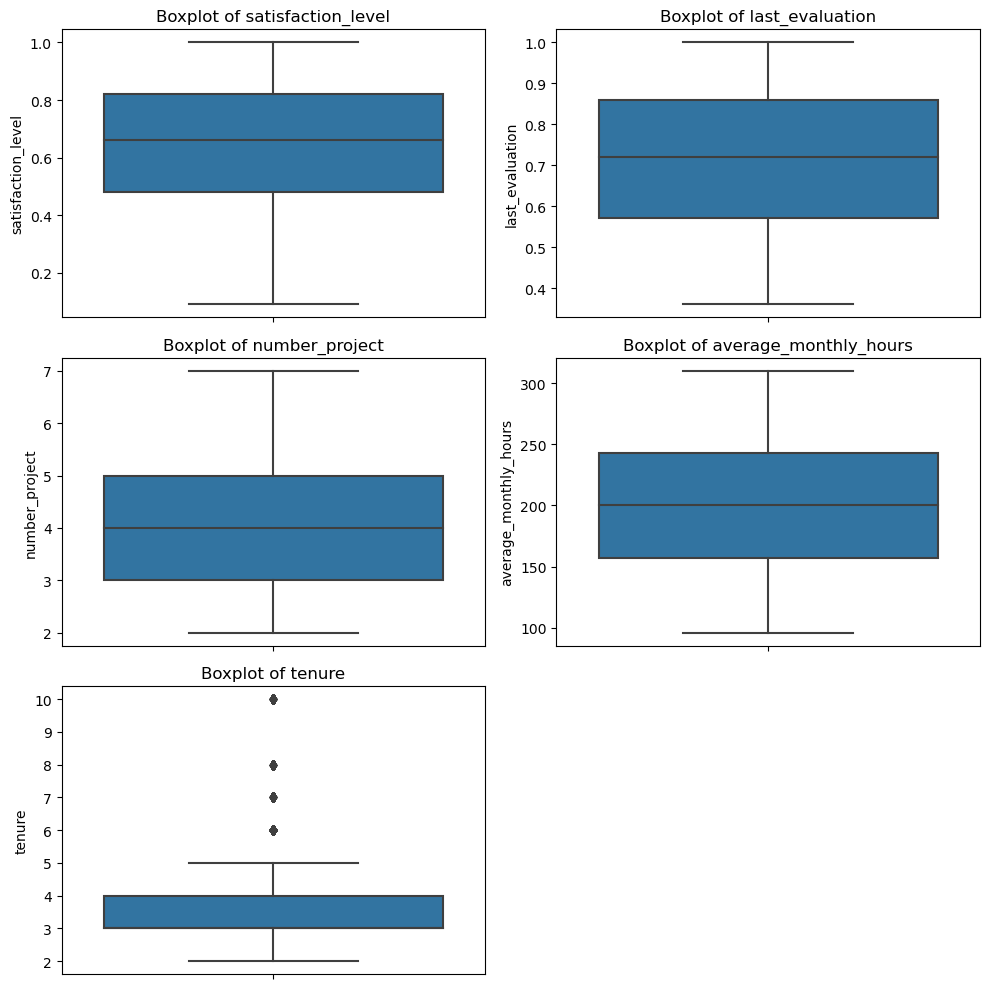

In [11]:
plt.figure(figsize=(10, 10))
X = df[['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'tenure']]
for i, col in enumerate(X.columns, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

In [12]:
# Calculating the interquartile range (IQR) for the 'tenure' feature to identify outliers
percentile25 = df['tenure'].quantile(0.25)
percentile75 = df['tenure'].quantile(0.75)

iqr = percentile75 - percentile25
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr
print("Lower limit:", lower_limit)
print("Upper limit:", upper_limit)
# Identify subset of data containing outliers in `tenure`
outliers = df[(df['tenure'] > upper_limit) | (df['tenure'] < lower_limit)]

# Count how many rows in the data contain outliers in `tenure`
print("Number of rows in the data containing outliers in `tenure`:", len(outliers))

Lower limit: 1.5
Upper limit: 5.5
Number of rows in the data containing outliers in `tenure`: 824


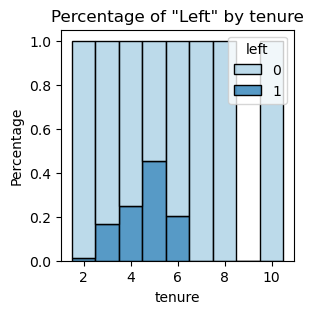

In [13]:
# Grouping the data by tenure to calculate the percentage of employees who left
tenure_counts = df.groupby('tenure')['left'].value_counts(normalize=True).rename('percentage').reset_index()

plt.figure(figsize=(3, 3))
sns.histplot(
    data=tenure_counts,
    x='tenure',
    weights='percentage',
    palette=sns.color_palette("Paired", 2),
    hue='left',
    multiple='stack',
    discrete=True
)
plt.ylabel('Percentage')
plt.title('Percentage of "Left" by tenure')
plt.show()

This indicates that the majority of employees who left the company had a tenure of 3-5 years, with a particularly high turnover rate at the 5-year mark.

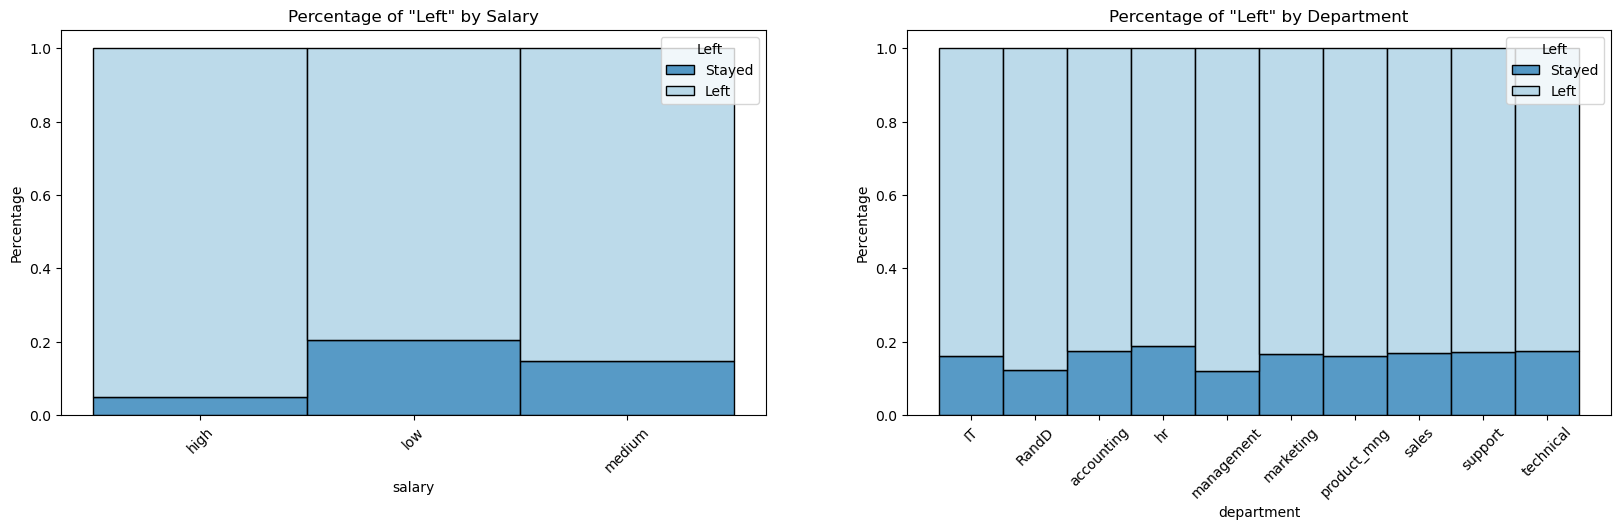

In [14]:
# Grouping the data by salary and department to calculate the percentage of employees who left
salary_counts = df.groupby('salary')['left'].value_counts(normalize=True).rename('percentage').reset_index()
department_counts = df.groupby('department')['left'].value_counts(normalize=True).rename('percentage').reset_index()

fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# First graph: Percentage of "Left" by salary
sns.histplot(
    data=salary_counts,
    x='salary',
    hue='left',
    weights='percentage',
    multiple='stack',
    palette=sns.color_palette("Paired", 2),
    discrete=True,
    ax=ax[0]  
)
ax[0].tick_params(axis='x', rotation=45) 
ax[0].set_ylabel('Percentage')
ax[0].set_title('Percentage of "Left" by Salary')
ax[0].legend(title='Left', labels=['Stayed', 'Left'])  # Manually set legend labels

# Second graph: Percentage of "Left" by department
sns.histplot(
    data=department_counts,
    x='department',
    hue='left',
    weights='percentage',
    multiple='stack',
    palette=sns.color_palette("Paired", 2),
    discrete=True,
    ax=ax[1]  
)
ax[1].tick_params(axis='x', rotation=45)
ax[1].set_ylabel('Percentage')
ax[1].set_title('Percentage of "Left" by Department')
ax[1].legend(title='Left', labels=['Stayed', 'Left'])  # Manually set legend labels

plt.show()


- The histogram shows that employees with lower salaries are more likely to leave the company.
- This indicates that financial compensation could be a key factor influencing employee turnover, especially among lower-paid employees.
- The histogram shows that the percentage of employees who leave is relatively consistent across most departments, with the exception of Management and R&D, where the rates differ slightly.
- This consistency suggests that the department might not be a major factor in turnover for most employees. The uniformity across departments indicates that other factors, such as overall company policies or external economic conditions, could be more influential in driving turnover.


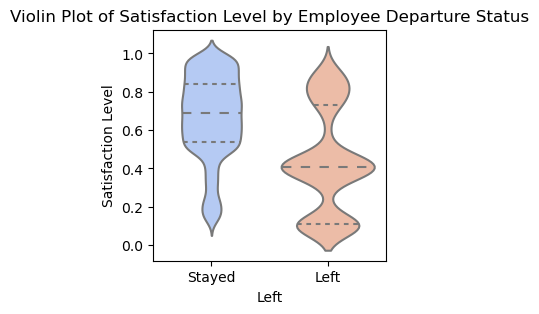

In [15]:
plt.figure(figsize=(3,3))
sns.violinplot(x='left', y='satisfaction_level', data=df, palette=sns.color_palette("coolwarm", 2),inner='quartile')
plt.xlabel('Left')
plt.ylabel('Satisfaction Level')
plt.title('Violin Plot of Satisfaction Level by Employee Departure Status')
plt.xticks([0, 1], ['Stayed', 'Left'])
plt.show()

- The violin plot shows a clear difference in satisfaction levels between employees who stayed and those who left.
- Employees who left the company generally had lower satisfaction levels compared to those who stayed, with a noticeable concentration of lower satisfaction scores among those who departed.
- This insight suggests that job satisfaction is strongly associated with employee retention, as lower satisfaction levels are more prevalent among those who chose to leave.


In [16]:
promotion_tenure = df.groupby(['tenure', 'promotion_last_5years']).size().reset_index(name='count')
promotion_tenure['percentage'] = promotion_tenure['count'] / promotion_tenure.groupby('tenure')['count'].transform('sum') * 100
promotion = df[df['promotion_last_5years'] ==1]

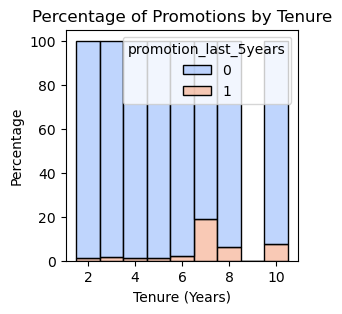

In [17]:
plt.figure(figsize=(3,3))
sns.histplot(
    data=promotion_tenure,
    x='tenure',
    weights='percentage',
    hue='promotion_last_5years',
    multiple='stack',
    palette=sns.color_palette("coolwarm", 2),
    discrete=True
)

plt.xlabel('Tenure (Years)')
plt.ylabel('Percentage')
plt.title('Percentage of Promotions by Tenure')
plt.show()

- The likelihood of receiving a promotion only starts to increase significantly around the 7th year of tenure. This suggests that employees may have to wait several years before seeing career advancement, which could potentially impact job satisfaction and turnover rates during the earlier years.

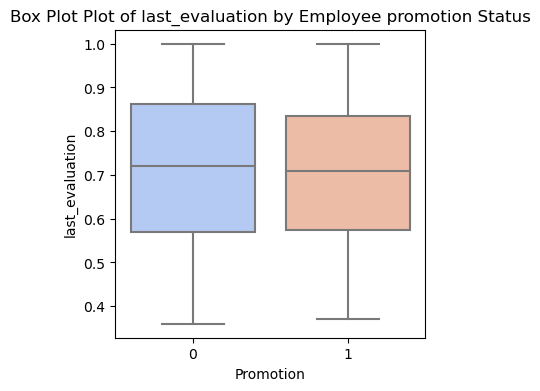

In [18]:
plt.figure(figsize=(4,4))
sns.boxplot(x='promotion_last_5years', y='last_evaluation',palette=sns.color_palette("coolwarm", 2), data=df)
plt.xlabel('Promotion')
plt.title('Box Plot Plot of last_evaluation by Employee promotion Status')
plt.show()

- The boxplot shows no significant difference in the last evaluation scores between employees who were promoted ) and those who were not
- Despite the similar evaluation scores, only 2% of employees received a promotion, with most promotions occurring after around 7 years of tenure. This indicates that the company is not providing enough opportunities for promotion

In [19]:
promotion_counts = df.groupby(['promotion_last_5years','salary'])['left'].value_counts(normalize=True).rename('percentage').reset_index()
promotion_counts

,promotion_last_5years,salary,left,percentage
0,0,high,0,0.949260
1,0,high,1,0.050740
2,0,low,0,0.794984
3,0,low,1,0.205016
4,0,medium,0,0.850973
5,0,medium,1,0.149027
6,1,high,0,1.000000
7,1,low,0,0.868421
8,1,low,1,0.131579
9,1,medium,0,0.975207


/Users/orlahav/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


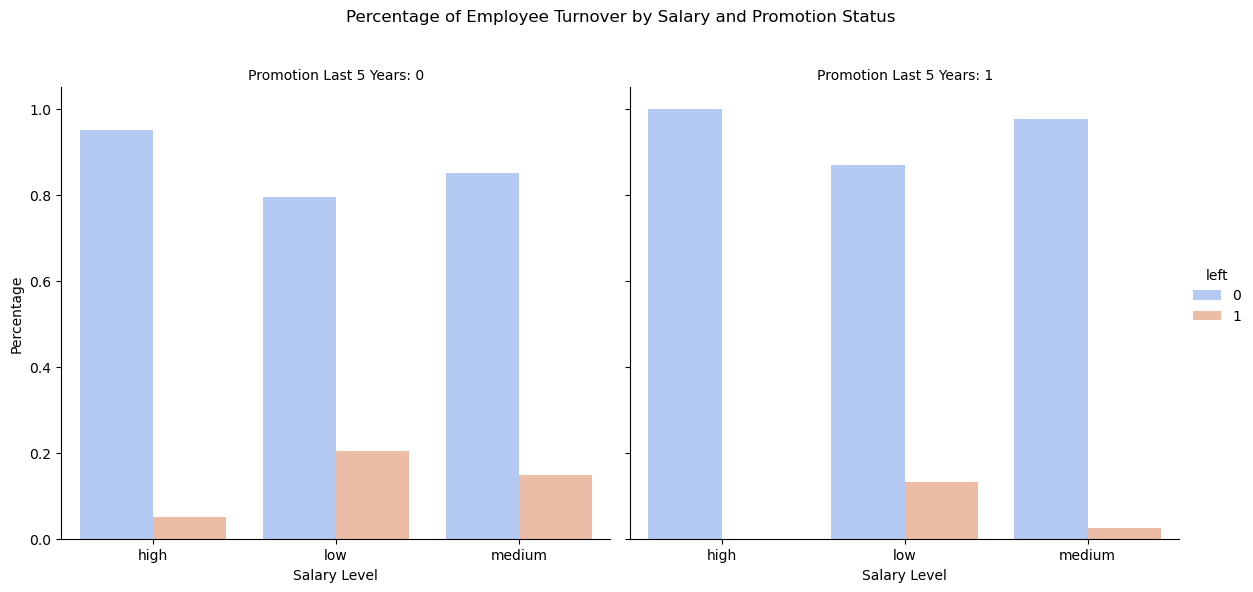

In [20]:
g = sns.catplot(
    data=promotion_counts,
    x='salary', y='percentage', hue='left',
    col='promotion_last_5years',
    kind='bar', 
    palette=sns.color_palette("coolwarm", 2),
    height=6, aspect=1
)

# Customize the plot
g.set_axis_labels("Salary Level", "Percentage")
g.set_titles("Promotion Last 5 Years: {col_name}")
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Percentage of Employee Turnover by Salary and Promotion Status')

    
plt.show()

- Employees who were not promoted have higher turnover rates across all salary levels compared to those who were promoted.

 - A typical full-time work schedule is 9 hours per day, 5 days a week.
This amounts to 45 hours per week (9 hours/day * 5 days/week).
Over a typical 4-week month, this would total 180 hours (45 hours/week * 4 weeks).
The 195-hour mark exceeds this typical monthly total, suggesting that employees who work more than 195 hours per month are likely putting in significant overtime.

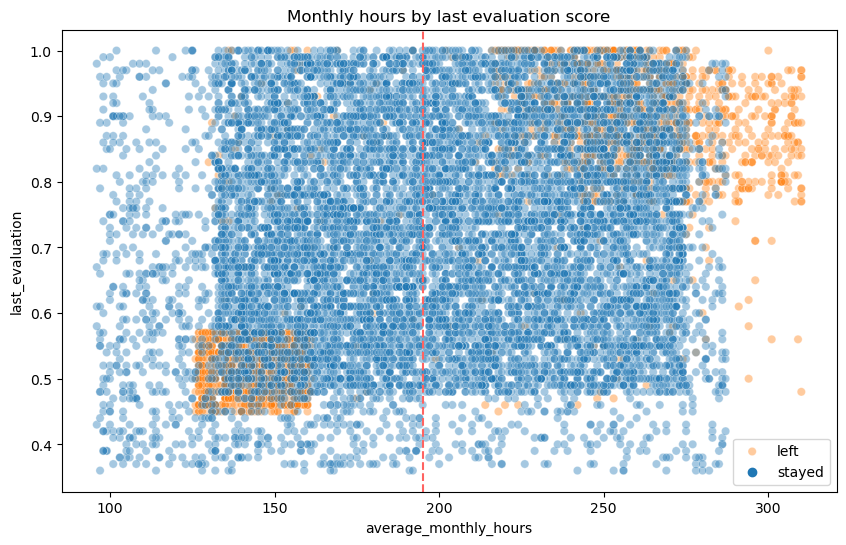

In [21]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='average_monthly_hours', y='last_evaluation', hue='left', alpha=0.4)
plt.axvline(x=195, color='#ff6361', label='166.67 hrs./mo.', ls='--')
plt.legend(labels=[ 'left', 'stayed'])
plt.title('Monthly hours by last evaluation score', fontsize='12');

- The combination of high performance (as indicated by last evaluation scores) and excessive work hours without corresponding recognition or promotion is leading to higher turnover rates among these valuable employees. This suggests that the company's failure to reward hard work and excellence with promotions is causing dissatisfaction and prompting these top performers to leave.

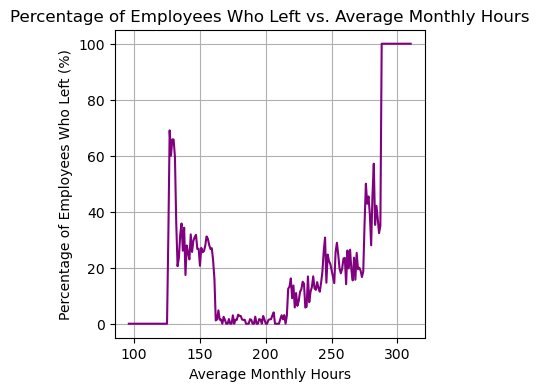

In [22]:
left_percentage = df.groupby('average_monthly_hours')['left'].mean()
bins = range(150, 350, 20)
df['hour_bin'] = pd.cut(df['average_monthly_hours'], bins)
# Filter only the cases where left = 1 (proportion)
left_percentage = left_percentage * 100  # Convert to percentage

# Plotting the result
plt.figure(figsize=(4, 4))
left_percentage.plot(kind='line', color='purple')
plt.title('Percentage of Employees Who Left vs. Average Monthly Hours')
plt.xlabel('Average Monthly Hours')
plt.ylabel('Percentage of Employees Who Left (%)')
plt.grid(True)
plt.show()


-  Employees working more than 220 average monthly hours show a rising trend in leaving the company, likely due to burnout or poor work-life balance. This trend peaks at 300+ hours, where turnover reaches 100%, indicating that such extreme workloads are unsustainable and lead to inevitable employee attrition.

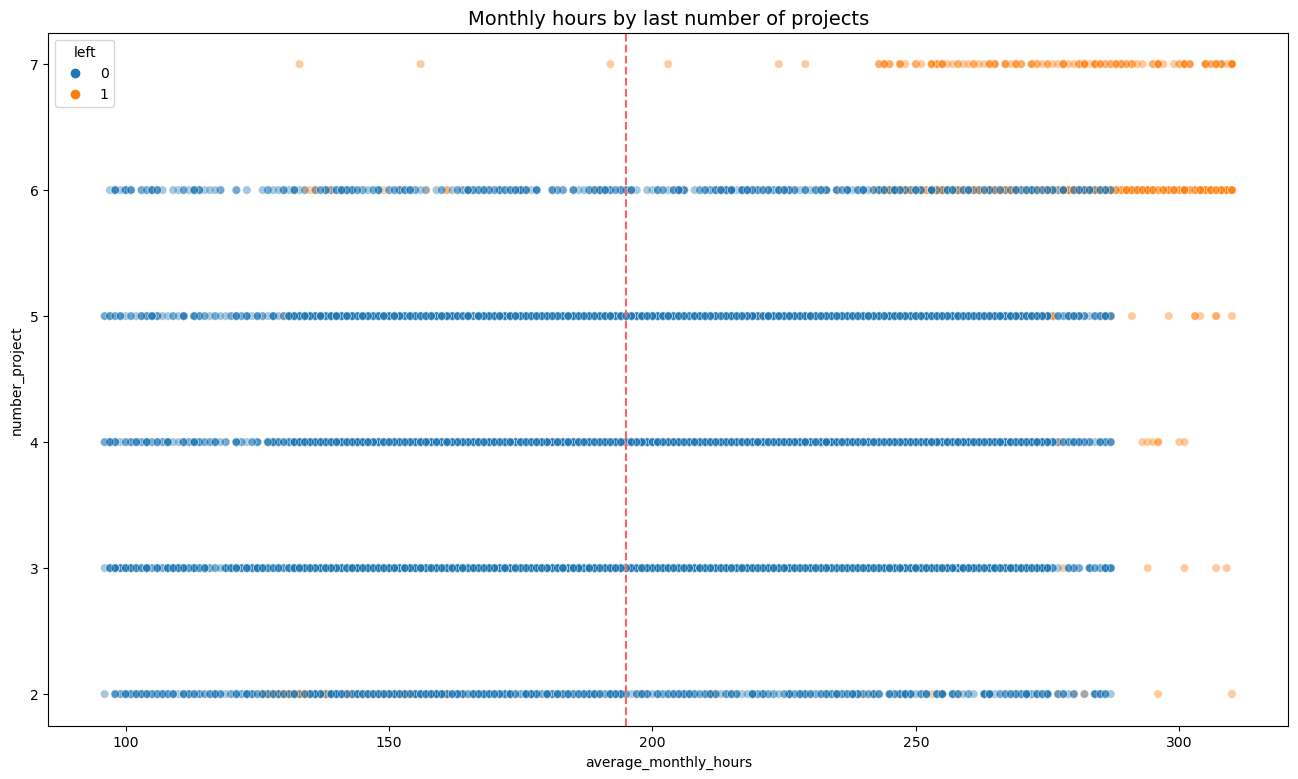

In [23]:
plt.figure(figsize=(16, 9))
sns.scatterplot(data=df, x='average_monthly_hours', y='number_project', hue='left', alpha=0.4)
plt.axvline(x=195, color='#ff6361', label='195 hrs./mo.', ls='--')
plt.title('Monthly hours by last number of projects', fontsize='14');

- This indicates that employees who are overloaded with both high work hours and a large number of projects are at a higher risk of burnout and turnover.

## Key Insights & Recommendations

#### Key Insights:

- Turnover rates are relatively consistent across all departments, except for Management and R&D.
  This suggests that factors influencing turnover may be more related to company-wide policies or culture rather     than specific departmental issues.
  
- There is a clear correlation between salary levels and employee retention, with higher-paid employees less likely   to leave the company

- The overall promotion rate in the company is notably low, with few employees receiving promotions, particularly during the early years of their tenure. This lack of career advancement opportunities, even among employees who demonstrate high performance—indicated by high evaluation scores and significant work hours—may contribute to dissatisfaction and increased turnover

- Excessive workloads, whether in the form of long work hours or a high number of projects, are strong predictors of employee turnover. Employees burdened with too many projects or extensive working hours are more likely to leave

- Employees who have been promoted are more likely to stay with the company, regardless of their salary level.


#### Recommendations
- **Increase Promotion Opportunities:**
  Given that promotions are a significant factor in retention, the company should consider reviewing its promotion policies to ensure that high-performing employees and those with a reasonable tenure are recognized and advanced in their careers.

- **Address Overwork:** 
  To prevent burnout, it is crucial to manage workloads, especially for employees with high project counts or extensive monthly hours. Implementing work-life balance initiatives and ensuring fair workload distribution could reduce turnover.

- **Recognize and Retain High Performers:** 
  The company should focus on recognizing and rewarding high-performing employees who contribute significantly to the company's success. This could include more frequent promotions, performance bonuses, or other incentives.

### Logistic Regression

In [24]:
# Create a copy of the original dataset to preserve the original data
df_enc = df.copy()

# Encode the `salary` column as an ordinal numeric category
df_enc['salary'] = (
    df_enc['salary'].astype('category')
    .cat.set_categories(['low', 'medium', 'high'])
    .cat.codes
)

# Dummy encode the `department` column
df_enc = pd.get_dummies(df_enc, drop_first=False)

# Display the new dataframe
df_enc.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,...,department_technical,"hour_bin_(150, 170]","hour_bin_(170, 190]","hour_bin_(190, 210]","hour_bin_(210, 230]","hour_bin_(230, 250]","hour_bin_(250, 270]","hour_bin_(270, 290]","hour_bin_(290, 310]","hour_bin_(310, 330]"
0,0.38,0.53,2,157,3,0,1,0,0,False,...,False,True,False,False,False,False,False,False,False,False
1,0.80,0.86,5,262,6,0,1,0,1,False,...,False,False,False,False,False,False,True,False,False,False
2,0.11,0.88,7,272,4,0,1,0,1,False,...,False,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,1,0,0,False,...,False,False,False,False,True,False,False,False,False,False
4,0.37,0.52,2,159,3,0,1,0,0,False,...,False,True,False,False,False,False,False,False,False,False


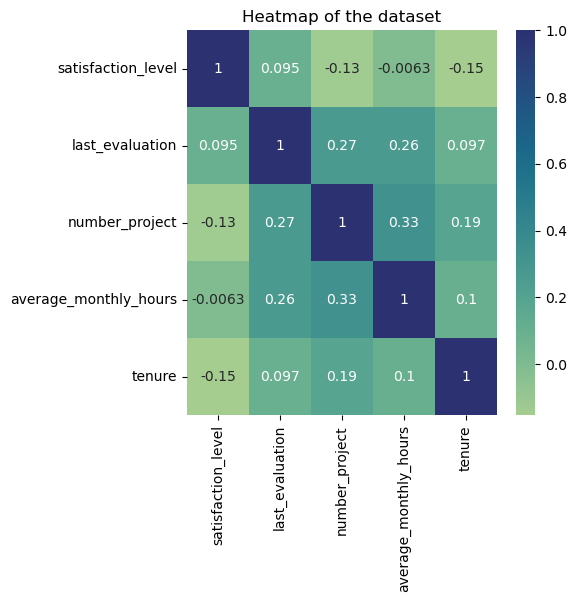

In [25]:
# Create a heatmap to visualize how correlated variables are
plt.figure(figsize=(5,5))
sns.heatmap(df_enc[['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'tenure']]
            .corr(), annot=True, cmap="crest")
plt.title('Heatmap of the dataset')
plt.show()

In [26]:
#filter out outliers i found at EDA stage
df_logreg = df_enc[(df_enc['tenure'] >= lower_limit) & (df_enc['tenure'] <= upper_limit)]
df_logreg.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,...,department_technical,"hour_bin_(150, 170]","hour_bin_(170, 190]","hour_bin_(190, 210]","hour_bin_(210, 230]","hour_bin_(230, 250]","hour_bin_(250, 270]","hour_bin_(270, 290]","hour_bin_(290, 310]","hour_bin_(310, 330]"
0,0.38,0.53,2,157,3,0,1,0,0,False,...,False,True,False,False,False,False,False,False,False,False
2,0.11,0.88,7,272,4,0,1,0,1,False,...,False,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,1,0,0,False,...,False,False,False,False,True,False,False,False,False,False
4,0.37,0.52,2,159,3,0,1,0,0,False,...,False,True,False,False,False,False,False,False,False,False
5,0.41,0.50,2,153,3,0,1,0,0,False,...,False,True,False,False,False,False,False,False,False,False


In [27]:
# Define the target variable `y` as the `left` column from the filtered DataFrame
y = df_logreg['left']

# Define the feature matrix `X` by dropping the target variable `left` from the DataFrame
X = df_logreg.drop('left', axis =1)

In [28]:
df_logreg['left'].value_counts(normalize=True)

left
0    0.831468
1    0.168532
Name: proportion, dtype: float64

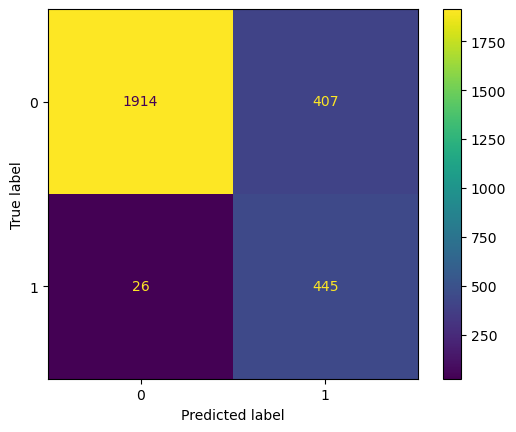

In [29]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
# Define the model with class weights
log_clf = LogisticRegression(max_iter=1000, class_weight='balanced').fit(X_train, y_train)

# Predict on the test set
y_pred = log_clf.predict(X_test)
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred, labels=log_clf.classes_)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, 
                                  display_labels=log_clf.classes_)

# Plot confusion matrix
log_disp.plot(values_format='')

# Display plot
plt.show()

- True Positives (TP): Correct predictions where the employee left the company.
- True Negatives (TN): Correct predictions where the employee stayed with the company.
- False Positives (FP): Incorrect predictions where the model predicted the employee would leave, but they stayed.
- False Negatives (FN): Incorrect predictions where the model predicted the employee would stay, but they left.

In [30]:
# Evaluate the model
target_names = ['Predicted would not leave', 'Predicted would leave']
print(classification_report(y_test, y_pred, target_names=target_names))

                           precision    recall  f1-score   support

Predicted would not leave       0.99      0.82      0.90      2321
    Predicted would leave       0.52      0.94      0.67       471

                 accuracy                           0.84      2792
                macro avg       0.75      0.88      0.79      2792
             weighted avg       0.91      0.84      0.86      2792



The logistic regression model achieved 84% accuracy. It performs well in predicting employees who stay, with a high precision (0.99) and recall (0.82). For predicting employees who leave, the recall is excellent (0.94), meaning the model effectively identifies most leavers. However, precision for predicting leavers is lower (0.52), indicating a relatively high number of false positives. Future improvements should focus on increasing precision for predicting who will leave to reduce false alarms.
